In [361]:
%reload_ext sql

In [362]:
%sql postgresql://chrble@/chrble

u'Connected: chrble@chrble'

In [913]:
%sql SELECT * FROM traffic.measurements LIMIT 5;

5 rows affected.


objectid,date,velo_in,velo_out,ped_in,ped_out,place
3219797,2015-06-22 10:00:00,2,5,0,0,ECO09113500
3219798,2015-06-22 10:15:00,6,6,0,0,ECO09113500
3219799,2015-06-22 10:30:00,4,3,0,0,ECO09113500
3219800,2015-06-22 10:45:00,5,1,0,0,ECO09113500
3219801,2015-06-22 11:00:00,3,3,0,0,ECO09113500


In [25]:
all_places=%sql SELECT DISTINCT p.descr,p.direction_in,p.direction_out,p.east_wgs,p.north_wgs FROM traffic.measurements as m JOIN traffic.places as p ON (m.place=p.place_id);

49 rows affected.


In [123]:
%%sql

CREATE VIEW interesting_places AS SELECT s.place_id,s.count,s.years,p.descr,p.east_wgs,p.north_wgs FROM 
traffic.sensors as s 
INNER JOIN 
traffic.places as p 
ON (s.place_id=p.place_id) 
WHERE ARRAY[2013,2014,2015,2016] <@ s.years;

Done.


[]

In [967]:
interesting_places=%sql SELECT * FROM interesting_places;
velo_places=%sql SELECT DISTINCT p.place_id,p.descr FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE NOT m.velo_num = 0 ;

21 rows affected.
13 rows affected.


place_id,descr
ECO09113502,Andreasstrasse
ECO09113503,Sihlpromenade
ECO09113500,Binzmühlestrasse
ECO09113507,Hofwiesenstrasse
ECO09113501,Scheuchzerstrasse
Y0412032046,Kloster-Fahr-Weg
ECO10053914,Schulstrasse
ECO09113499,Mythenquai
Y0410090357,Fischerweg
Y2G12102806,Mühlebachstrasse


In [896]:
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
import cv2,time,calendar,math
from datetime import date
import seaborn as sea
sea.set_style("whitegrid", {'axes.grid' : False})
from ipywidgets import *
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
import matplotlib.cm as cm
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 22})

In [666]:
def get_nums(y):
    numbers =%sql SELECT * FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE m.year = $y ;
    return numbers

21 rows affected.
time1: 0.0498678684235


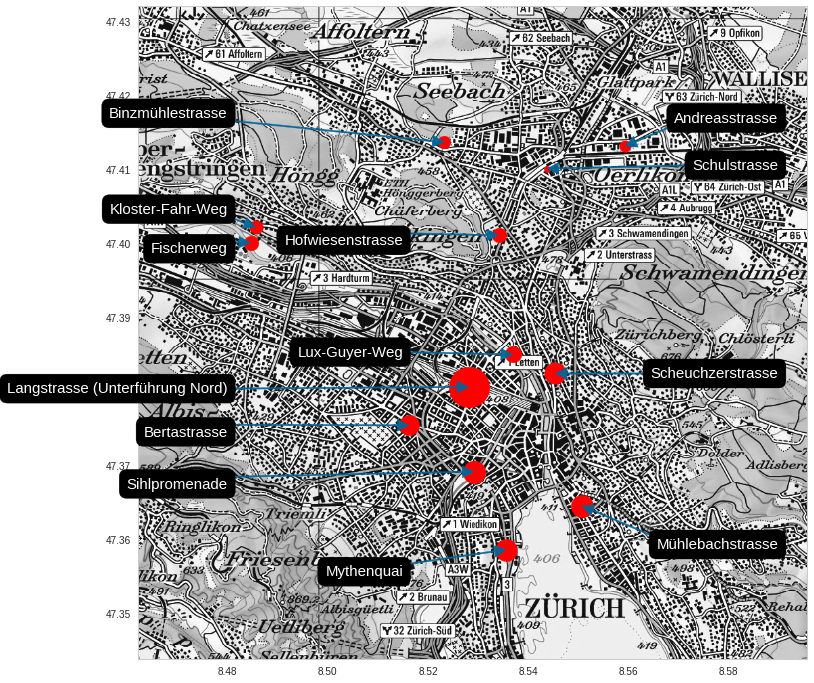

time4: 1.40325379372


In [667]:
img=cv2.imread("Zurich_map.png")
colors=cm.ScalarMappable(cmap="plasma").to_rgba(range(len(interesting_places)))
grey_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
orig_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

@interact(year=Dropdown(options=range(2010,2017)[::-1], description='year',layout=Layout(width='10%',)),
         mot=RadioButtons(options=["bicyclists","pedestrians"],description="transport",layout=Layout(width="40%")))
def show_map(year,mot):
    start_time=time.time()
    fig,ax = plt.subplots(figsize=(12,12))
    plt.ylim(47.34392,47.43197) 
    plt.xlim(8.46202,8.59580)
    ax.imshow(grey_image, extent=[8.46202,8.59580,47.34392,47.43197],aspect="auto",cmap='gray')
    numbers=get_nums(year)
    print "time1:",time.time()-start_time
    for i,p in enumerate(numbers):
        if mot=="bicyclists" and p[9]==0:
            continue
        if mot=="pedestrians" and p[8]==0:
            continue
        plt.scatter(x=[p[4]],y=[p[5]],s=(p[9]/1000.0 if mot=="bicyclists" else p[8]/1000.0),color="Red")
        if p[4]<8.54 and p[4]>8.53:
            lt=8.515
        elif p[4]<8.54:
            lt=8.48
        else:
            lt=8.59
        if p[3] in [u"Hofwiesenstrasse",u"Fischerweg",u"Schulstrasse",u"Weinbergfussweg",u"Mühlebachstrasse",u"Militärbrücke"]:
            yt=p[5]+((p[5]-47.39)/8.0) -0.003
        else:
            yt=p[5]+((p[5]-47.39)/8.0)
        plt.annotate(
            p[3],
            xy=(p[4], p[5]), xytext=(lt, yt), fontsize=15, color="white",
            textcoords='data', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='black',alpha=1,),
            arrowprops=dict( connectionstyle='arc3,rad=0',color=(0.0, 0.4, 0.6,0.95),width=1.5))
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0,fontsize=13)
    plt.show()
    print "time4:",time.time()-start_time

In [171]:
numbers

place_id,count,years,descr,east_wgs,north_wgs,year,place,ped_num,velo_num
ECO09022739,247451,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]",Lux-Guyer-Weg,8.53695406623,47.3849977821,2016.0,ECO09022739,0,280837
ECO09113499,220090,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Mythenquai,8.5356169115,47.3586546756,2016.0,ECO09113499,0,485215
ECO09113500,210631,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Binzmühlestrasse,8.52328638868,47.4136413252,2016.0,ECO09113500,0,160311
ECO09113501,219706,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Scheuchzerstrasse,8.54537722471,47.3824347007,2016.0,ECO09113501,0,468063
ECO09113502,211630,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Andreasstrasse,8.55933212897,47.4130814486,2016.0,ECO09113502,0,133500
ECO09113503,213956,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Sihlpromenade,8.52923988459,47.369185446,2016.0,ECO09113503,0,516483
ECO09113506,225147,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Bertastrasse,8.51625821804,47.3754330454,2016.0,ECO09113506,0,417484
ECO09113507,216621,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Hofwiesenstrasse,8.5341459376,47.4010807345,2016.0,ECO09113507,0,218500
ECO10053914,153971,"[2012, 2013, 2014, 2015, 2016]",Schulstrasse,8.54372588202,47.410083515,2016.0,ECO10053914,0,41680
U15G3063864,120903,"[2013, 2014, 2015, 2016]",Militärbrücke,8.53352226931,47.3752616237,2016.0,U15G3063864,1043611,0


21 rows affected.


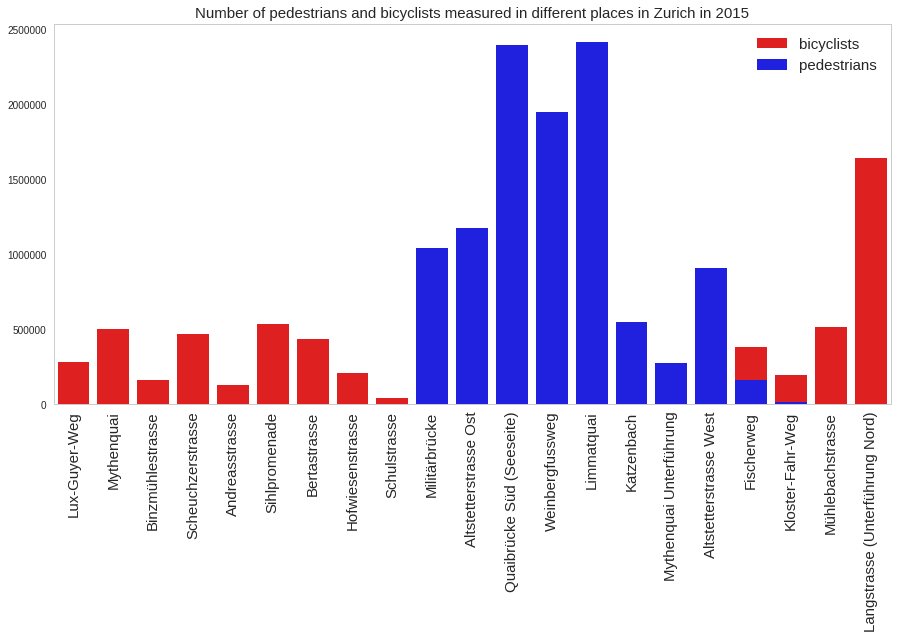

In [668]:
@interact(year=Dropdown(options=["2014", "2015", "2016"], description='year'))
def year_measures(year):
    numbers =%sql SELECT * FROM interesting_places as p INNER JOIN traffic.total_traffic as m ON (p.place_id=m.place) WHERE m.year = $year ;
    #sea.xticks([p[0] for p in interesting_places])
    plt.figure(figsize=(15,7))

    plt.title("Number of pedestrians and bicyclists measured in different places in Zurich in "+year,fontsize=15)
    plt.xticks(rotation="vertical",fontsize=15)
    sea.barplot([p[3] for p in numbers],[p[8]+p[9] for p in numbers],color="red",label="bicyclists")
    sea.barplot([p[3] for p in numbers],[p[8] for p in numbers],color="blue",label="pedestrians")
    plt.legend(fontsize=15)
    plt.show()

In [672]:
# Fit a line to some data using least squares minimization

from scipy.optimize import leastsq

def yfit_linear(x, a):  
    return a[0] + a[1] * x
    
def yfit_quadratic(x,a):
    return a[0] + a[1] * x + a[2] * x**2 
    
def funcdiff_linear(a, xdata, ydata):   
    return yfit_linear(xdata, a) - ydata
    
def funcdiff_quadratic(a, xdata, ydata):   
    return yfit_quadratic(xdata, a) - ydata
 
def fit_regression(X,y):
    print "pearson coefficient: ",pearsonr(X[:,1],y)
    a_init = np.array([0.,0.,0.])
    result = leastsq(funcdiff_quadratic, a_init, args=(X[:,1],y))
    yfit = yfit_quadratic(np.array(range(1,13)),result[0])
    return yfit
    

48 rows affected.
pearson coefficient:  (0.3179987611752299, 0.027622266357577523)


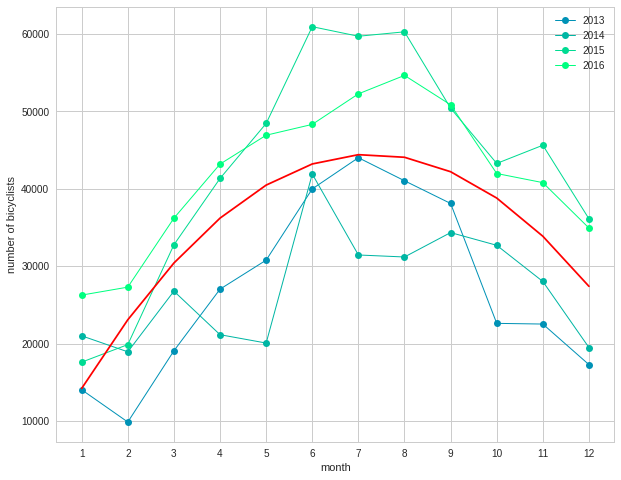

In [968]:
colors=cm.ScalarMappable(cmap="winter").to_rgba(range(2009,2017))
colors={y:c for y,c in zip(range(2009,2017),colors)}
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
          years=SelectMultiple(options=range(2009,2017)[::-1], value=[2013,2014,2015,2016]))
def plot_regression(place,years):
    years_q=list(years)
    fig,ax=plt.subplots()
    
    data=%sql SELECT * FROM traffic.monthly_traffic WHERE place='$place' AND year::int = ANY (ARRAY$years_q);
    X,y = np.array([d[:2] for d in data]),np.array([d[3] for d in data])
    for year in years:
        ax.plot([m for ye,m in list(X) if int(ye)==year],[t for (ye,m),t in zip(list(X),list(y)) if int(ye)==year],
                 color=colors[int(year)],label=int(year),marker='o',lw=1.0)
    #plt.plot(X[:,1],y,c=colors)
    yf=fit_regression(X,y)
    plt.ylabel("number of bicyclists")
    plt.xlabel("month")
    plt.grid(True)
    ax.set_xticks(range(13))
    ax.plot(range(1,13),yf,color="red")
    ax.legend()
    plt.show()

1090 rows affected.


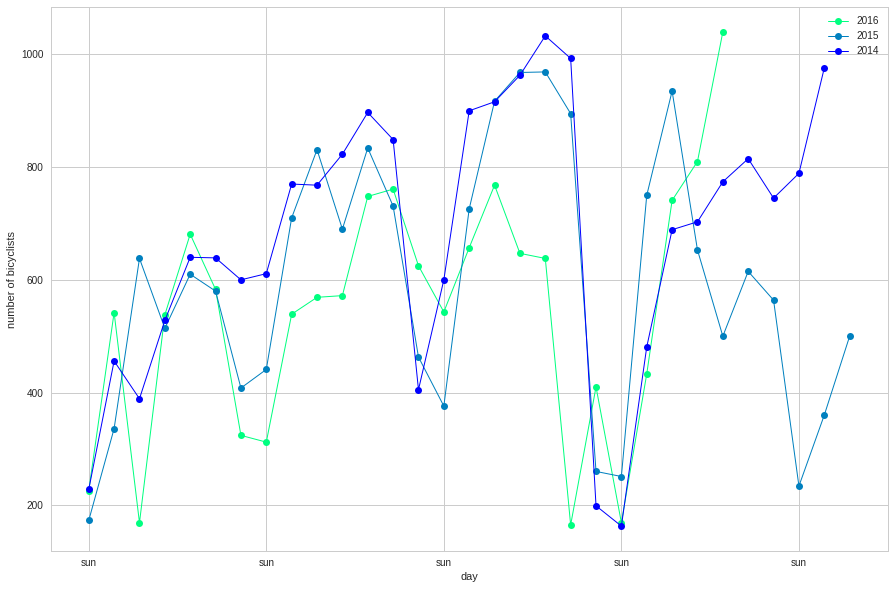

In [792]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
         years=SelectMultiple(options=range(2009,2017)[::-1], value=[2016]),
         months=SelectMultiple(options=range(1,13), value=list(range(1,13))),
         align_weekdays=ToggleButton(value=False,icon="check",layout=Layout(margin="0 0 0 120px")))
def plot_stuff(place,years,months,align_weekdays):
    years_q=list(years)
    colors=cm.ScalarMappable(cmap="winter").to_rgba(years)
    colors={y:c for y,c in zip(years,colors)}
    fig,ax=plt.subplots(figsize=(15,10))
    
    data=%sql SELECT year,month,day,SUM(velo_num)  FROM traffic.hourly_traffic WHERE place='$place' AND year::int = ANY (ARRAY$years_q) GROUP BY day,month,year ORDER BY month,day;
    X,y = np.array([d[:3] for d in data]),np.array([float(d[3]) for d in data])
    for year in years:
        x_inp=filter(lambda (ye,m,d): int(ye)==year and int(m) in months, list(X))
        y_inp=[t for (ye,m,d),t in zip(list(X),list(y)) if int(ye)==year and int(m) in months]
        
        week_start=0
        if align_weekdays:
            x_ticks=[i for i,(ye,m,d) in enumerate(filter(lambda (ye,m,d): int(ye)==year and int(m) in months, list(X))) if date(int(ye),int(m),int(d)).weekday()==6]
            ax.set_xticks([x-x_ticks[0] for x in x_ticks])
            ax.set_xticklabels(["sun" for i in [x-x_ticks[0] for x in x_ticks]])
            x_inp=x_inp[x_ticks[0]:]
            y_inp=y_inp[x_ticks[0]:]
        ax.plot([i for i,o in enumerate(x_inp)],y_inp, color=colors[int(year)],label=(int(year)),marker='o',lw=1.0)
    #plt.plot(X[:,1],y,c=colors)
    plt.ylabel("number of bicyclists")
    plt.xlabel("day")
    plt.grid(True)
        
    #ax.plot(range(1,13),yf,color="red")
    ax.legend()
    plt.show()

In [557]:
%sql select * from traffic.weather LIMIT 5;

5 rows affected.


date,airtemp,watertemp,windbo,windspeed,windstr,winddir,windc,press,precip,ice,rad,hum,pegel
2010-01-01,3.9,5.8,8.1,0.2,0.0,227.7,3.8,947.0,5.7,2.0,19.5,87.8,405.9
2010-01-02,-1.3,5.6,10.7,0.7,1.0,271.7,-2.0,968.0,0.2,-7.0,53.0,65.8,405.9
2010-01-03,-3.5,5.2,3.5,0.0,0.0,192.3,-3.5,972.4,0.0,-8.5,79.9,69.5,405.8
2010-01-04,-4.9,4.9,2.9,0.0,0.0,280.5,-4.9,966.0,0.0,-8.0,67.6,79.2,405.8
2010-01-05,-4.3,4.9,3.0,0.0,0.0,190.7,-4.3,957.4,0.6,-6.6,23.0,84.2,405.8


In [879]:
def get_weather(place):
    dtw=%sql SELECT d.day,d.month,d.year,d.velo_num,w.precip,w.airtemp,w.windstr,EXTRACT(dow FROM w.date) as dow FROM (SELECT day,month,year, SUM(velo_num) as velo_num FROM traffic.hourly_traffic WHERE place='$place' GROUP BY day,month,year,place) as d JOIN traffic.weather as w ON(to_date(d.month::int8::varchar||' '||d.day::int8::varchar||' '||d.year::int8::varchar,'MM DD YYYY')=w.date);
    return dtw

2209 rows affected.
pearson coefficient:  (-0.23760180732835018, 1.0038204922883229e-29)


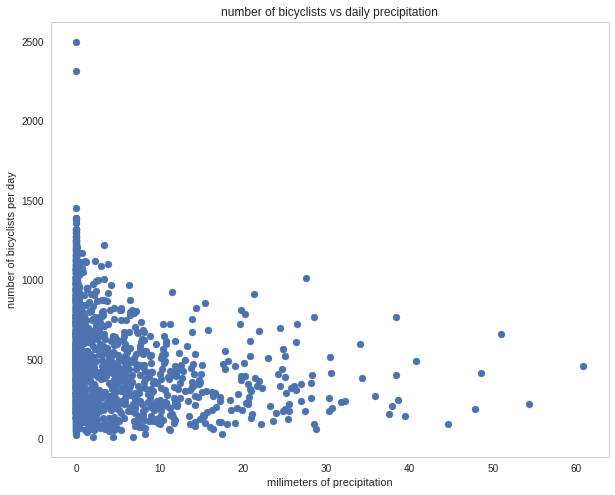

In [888]:
#print np.median(X)
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),
         param=Dropdown(options=["Precipitation","Temperature","Windstrength"]))
def weather_show(place,param):
    dtw = get_weather(place)
    y = [float(d[3]) for d in dtw]
    X1 = [float(d[5]) for d in dtw]
    X2 = [float(d[4]) for d in dtw]
    X3 = [float(d[6]) for d in dtw]
    X4 = [float(d[7]) for d in dtw]
    if param=="Precipitation":
        print "pearson coefficient: ",pearsonr(X2,y)
        plt.title("number of bicyclists vs daily precipitation")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("milimeters of precipitation")
        plt.scatter(X2,y)
    elif param=="Temperature":
        print "pearson coefficient: ",pearsonr(X1,y)
        plt.title("number of bicyclists vs temperature")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("temperature in Celcius")
        plt.scatter(X1,y)
    elif param== "Windstrength":
        print "pearson coefficient: ",pearsonr(X3,y)
        plt.title("number of bicyclists vs windstrength")
        plt.ylabel("number of bicyclists per day")
        plt.xlabel("windstrength (0-12)")
        sea.boxplot(X3,y)
        
    
    #sea.boxplot(X,y)
    plt.show()

2500 rows affected.
pearson coefficient:  (0.024828042709432591, 0.21461587988720152)


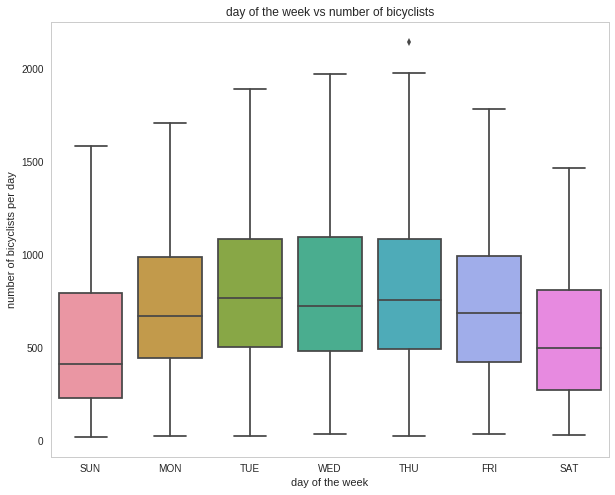

In [884]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}))
def plot_days_of_week(place):
    dtw = get_weather(place)
    X_dow = [float(d[7]) for d in dtw]
    y_dow = [float(d[3]) for d in dtw]

    print "pearson coefficient: ",pearsonr(X_dow,y_dow)
    plt.title("day of the week vs number of bicyclists")
    plt.xlabel("day of the week")
    plt.ylabel("number of bicyclists per day")

    ax=sea.boxplot(X_dow,y_dow)
    ax.set_xticklabels(["SUN","MON","TUE","WED","THU","FRI","SAT"])
    plt.show()

In [942]:
def cross_valid(k,data):
    splits=[]
    for i in range(k):
        start=int((1/float(k))*len(data)*i)
        stop=int((1/float(k))*len(data)*(i+1))
        test = data[start:stop]
        train = data[:start]+data[stop:]
        splits.append((train,test))
    return splits

2298 rows affected.


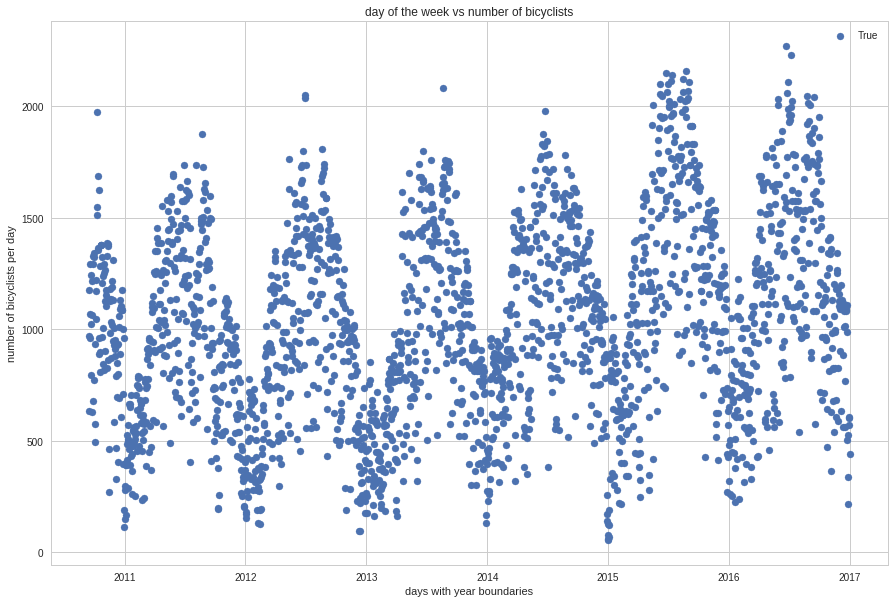

In [991]:
@interact(place=Dropdown(options={p[1]:p[0] for p in velo_places}),predict=Checkbox(value=False),
         features=SelectMultiple(options={"month":1,"year":2,"precip":4,"temp":5,"wind":6,"dow":7},value=[1,2,4,5,6,7]))
def mult_var_lr(place,predict,features):
    dtw = get_weather(place)
    X = np.array([[d[i] for i in features] for d in dtw])
    y = np.array([float(d[3]) for d in dtw])
    fig,ax=plt.subplots(figsize=(15,10))
    ax.scatter(range(X.shape[0]),y,label="True")
    if predict:
        prediction=[]
        scores=[]
        for train,test in cross_valid(5,[([d[i] for i in features],d[3]) for d in dtw]):
            lr=LinearRegression()
            lr.fit([feats for feats,targ in train],[targ for feats,targ in train])
            scores.append(lr.score([feats for feats,targ in test],[targ for feats,targ in test]))
            prediction+=list(lr.predict([feats for feats,targ in test]))
        ax.scatter(range(len(prediction)),prediction,label="Prediction")
        print "Coefficient of determination R^2: ",np.mean(scores)
    x_ticks = range(len(dtw),len(dtw)%365-1,-365)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(range(2017,2017-len(x_ticks),-1))
    plt.title("day of the week vs number of bicyclists")
    plt.xlabel("days with year boundaries")
    plt.ylabel("number of bicyclists per day")
    plt.grid(True)
    plt.legend()
    plt.show()

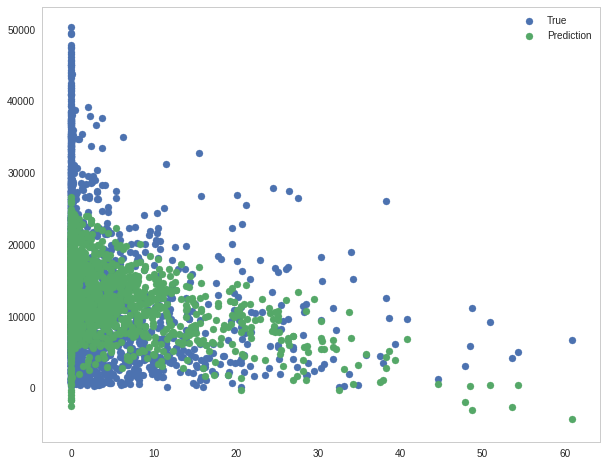

In [852]:
#plt.scatter([reduce(lambda x,y: x*y ,row) for row in X_test],y_test)
#plt.scatter([reduce(lambda x,y: x*y ,row) for row in X_test],lr.predict(X_test))


In [962]:
%sql SELECT * FROM interesting_places LIMIT 5;

5 rows affected.


place_id,count,years,descr,east_wgs,north_wgs
ECO09113500,210631,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Binzmühlestrasse,8.52328638868,47.4136413252
Y0412032046,228154,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Kloster-Fahr-Weg,8.48557195358,47.4021427627
ECO09113507,216621,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Hofwiesenstrasse,8.5341459376,47.4010807345
ECO09022739,247451,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]",Lux-Guyer-Weg,8.53695406623,47.3849977821
ECO09113499,220090,"[2010, 2011, 2012, 2013, 2014, 2015, 2016]",Mythenquai,8.5356169115,47.3586546756
